In [ ]:
#@title Install einops
!python -m pip install einops

# Task 3

**Note: for this section is is strongly recommended to use a GPU runtime. The code performs a lot of computations and using the GPU allows you to more quickly experiment around with the results.**

## The paper "Instant Neural Graphics Primitives with a Multiresolution Hash Encoding"

By now you have learned why it may be desirable to have an implicit neural representation (INR) either for solving a direct task or as an encoding for downstream tasks. You have also learned that it is not as simple as using a plain MLP or even one using a simple input encoding. The main focus of this homework - the [instant-ngp](https://arxiv.org/abs/2201.05989) paper - first introduced a method for efficiently training high-detail INRs in a very short amount of time on standard hardware. 

The paper mentions the drawbacks of existing methods, some of which you have already seen. They can roughly be summarized into the categories of *frequency encodings* and *parametric encodings*. An example for the former is the fourier feature encoding you have used in the previous part. These encodings make use of a global feature map, while the parametric encodings make use of additional parameters to provide location dependent features. They make it possible to express much more complex functions using comparatively little processing power. However, existing methods for this encoding scheme relied either on dense grids (very memory intensive with only a limited resolution) or on tree-like structures. Both are infeasible to implement on a larger scale and suffer from inefficiencies. Especially the case of 3D objects, dense grids only contain few grid points that are close to the surface of the object and therefore have a meaningful impact on the output. 

The new encoding proposed by the paper makes use of a **multiresolution sparse hash-indexed grid** (can be thought of as a hash map with N-dimensional vectors as keys; visualized in *Figure 3* below). Each level of the grid has a fixed number of parameters, and a spatial hash function (described in later parts) is used to index into the parameters. Notably, the encoding does not handle hash collisions explicitly. Instead, they are handled implicitly through the optimizer, where the gradients of colliding coordinates (meaning they map to the same index in a level) are averaged. This causes points with a large impact on the output to dominate the gradients, and therefore results in a natural tendency of the optimizer to prefer parameters that reflect the needs of the points with higher importance to the output.

The following questions will walk you through an implementation of the proposed hash grid in PyTorch. 

**It is advised to read through the following overview of the algorithm before you dive into the implementation.**

The algorithm uses $L$ levels for the hash grid, where each level contains $T$ parameters. The amount of parameters is minimal in $L_0$, maximal in $L_n$ and is set according to a predetermined function in each level $L_i$. The input into the hash grid lookup is the position $v \in \mathbb{R}^d$ of the sample point ($d=2$ for images; batched in the implementation) and the output is a feature vector composed of the concatenated results of the lookup for $v$ in each level. For the lookup in each level, the points in the hypercube around the sample position are calculated, then hashed using a spatial hash function (shown later), and then linearly interpolated (to ensure the encoding represents a continuous function to avoid a blocky appearance of the output).

**If anything is unclear, please look at section 3 of the paper for the full detail.**

Figure 3 of the paper shows this procedure very nicely and it is included here for your convenience.

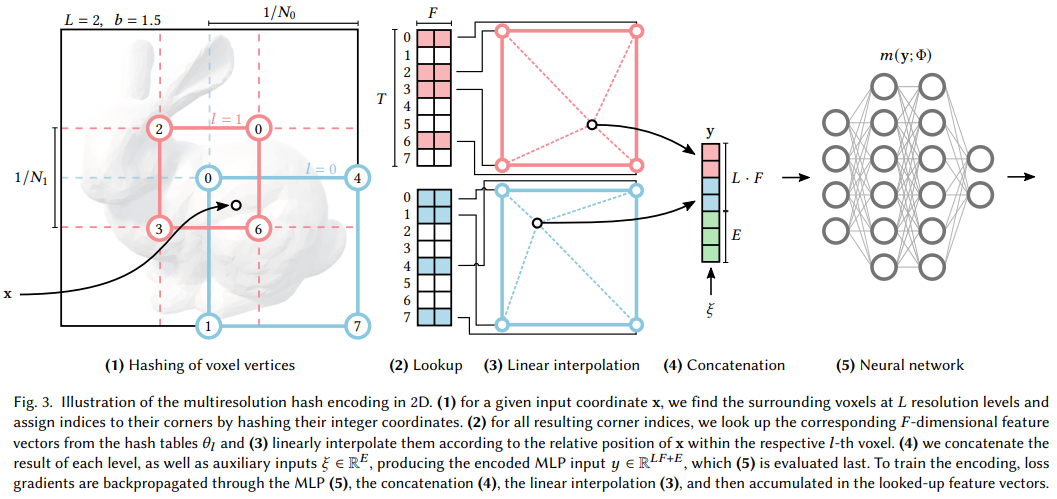

### Setup code

In [ ]:
from torch import nn, Tensor
import torch
from abc import ABC, abstractmethod
from typing import Tuple, Optional, List
import math
import einops
from tqdm import tqdm
import torchvision.transforms as T
import matplotlib.pyplot as plt
import urllib.request
from PIL import Image
import numpy as np
import time
import inspect
import json
%matplotlib inline

TO_SAVE = {"time": time.time()}

In [ ]:
########################################
# CHANGE IF YOU REALLY CANNOT USE A GPU.
# KEEP IN MIND THAT THIS WILL SLOW DOWN
# TRAINING BY A LOT.
########################################
allow_cpu = False
if not allow_cpu:
  assert torch.cuda.is_available()

if torch.cuda.is_available():
  print("USING GPU 😊")
  device = torch.device("cuda:0")
else:
  print("WARNING: NOT USING GPU 😡")
  device = torch.device("cpu")

In [ ]:
class HashGridConfig(ABC):
  @abstractmethod
  def level_resolution(self, level: int, num_levels: int, n_dim: int) -> Tuple[int, int]:
    """
    Returns a tuple of (level_resolution, level_parameters) for the given level.
    """
    pass

  def print_stats(self, n_levels: int, n_dim: int):
    """
    Print the statistics a grid with the given prameters using this config 
    would have, like the total number of parameters.
    """
    num_params = 0
    for l in range(n_levels):
      _, params = self.level_resolution(l, n_levels, n_dim)
      num_params += params
    print(f"Total parameters: {num_params}")

def load_picture(url) -> Tensor:
  raw_img = urllib.request.urlopen(url)
  img = Image.open(raw_img).convert('L')
  return torch.from_numpy(np.array(img)) / 255

def sample_image(img: Tensor, coords: Tensor) -> Tensor:
  h, w = img.shape
  coords = coords * torch.tensor([w-1, h-1], dtype=torch.float, device=coords.device)
  fract_coords = coords.frac()
  grid_coords = coords.floor().long()

  idx_scale = torch.tensor([1, w], dtype=torch.long, device=coords.device)
  off_a = torch.tensor([1, 0], dtype=torch.long, device=coords.device)
  off_b = torch.tensor([0, 1], dtype=torch.long, device=coords.device)
  off_c = torch.tensor([1, 1], dtype=torch.long, device=coords.device)
  img = img.flatten()
  a = img.index_select(0, (grid_coords * idx_scale).sum(1))
  b = img.index_select(0, ((grid_coords + off_a) * idx_scale).sum(1))
  c = img.index_select(0, ((grid_coords + off_b) * idx_scale).sum(1))
  d = img.index_select(0, ((grid_coords + off_c) * idx_scale).sum(1))

  x_lerp = fract_coords[:, ::2].squeeze()
  y_lerp = fract_coords[:, 1::2].squeeze()
  lerp_a = (1 - x_lerp) * a + x_lerp * b
  lerp_b = (1 - x_lerp) * c + x_lerp * d
  return (1 - y_lerp) * lerp_a + y_lerp * lerp_b

# This function is definitely correct and as tested properly
def full_img_coords(device, size: Tuple[int, int]) -> Tensor:
  x_pos = torch.arange(size[0], dtype=torch.int32, device=device)
  y_pos = torch.arange(size[1], dtype=torch.int32, device=device)
  x_pos = x_pos.repeat(size[1]).unsqueeze(0).float() / float(size[0])
  y_pos = y_pos.repeat_interleave(size[0]).unsqueeze(0).float() / float(size[1])
  coords = einops.rearrange([x_pos, y_pos], "t h w -> w (h t)")
  return coords

def render_image(device, model: nn.Module, size: Tuple[int, int], feature_mask: Optional[Tensor] = None) -> Tensor:
  coords = full_img_coords(device, size)
  pixels: Tensor = model.forward(coords, feature_mask)
  return einops.rearrange(pixels.reshape([size[1], size[0], -1]), "h w c -> c h w")

In [ ]:
def test_hash_coordinates():
    print("Testing hash_coordinates...")

    pi = torch.tensor([1, 5382572, 150393365])

    # Test simple hashing and data types
    x_a = torch.tensor([[10, 17, 1923]])
    a = hash_coordinates(x_a, pi)
    a_target = torch.tensor([1400385497], dtype=torch.int32)
    assert a.dtype == torch.int32, "Output does not have the correct type"
    assert torch.allclose(a, a_target, rtol=0), "Simple hashing doesn't work"

    # Test batched hashing
    x_b = torch.tensor([[10, 17, 1923], [5213, 293, 7593], [91872, 817, 28], [823, 154, 5236]])
    b = hash_coordinates(x_b, pi)
    b_target = torch.tensor([1400385497, -1094873764, -52238016, 1764267979], dtype=torch.int32)
    assert torch.allclose(b, b_target, rtol=0), "Batched hashing doesn't work"

    # Test preservation of other axis
    x_c = torch.ones(10, 5, 2, 9, 3, dtype=torch.int32)
    c = hash_coordinates(x_c, pi)
    assert c.shape == (10, 5, 2, 9), "The function removes more than one axis"

    TO_SAVE["hash_coordinates"] = inspect.getsource(hash_coordinates)

    print("All Tests Passed!")

def test_generate_binary_combinations():
    def compare_array_ignore_order(a, b):
        if len(a) != len(b):
            return False
        for v in a:
            if not v in b:
                return False
        return True

    print("Testing generate_binary_combinations...")

    a = generate_binary_combinations("cpu", 2).detach().int().numpy()
    a_target = [[0, 0], [0, 1], [1, 0], [1, 1]]
    assert compare_array_ignore_order(a.tolist(), a_target), "Binary combinations are not correct"

    b = generate_binary_combinations("cpu", 3).detach().int().numpy()
    b_target = [[0,0,0],[0,0,1],[0,1,0],[0,1,1],[1,0,0],[1,0,1],[1,1,0],[1,1,1]]
    assert compare_array_ignore_order(b.tolist(), b_target), "Binary combinations are not correct"

    TO_SAVE["generate_binary_combinations"] = inspect.getsource(generate_binary_combinations)

    print("All Tests Passed!")

def test_get_lookup_coordinates():
    print("Testing get_lookup_coordinates...")

    bin_comb = generate_binary_combinations("cpu", 2)
    rng = torch.Generator()
    rng.manual_seed(12345)

    # Test simple case with one layer
    level_resolutions = torch.tensor([16], dtype=torch.int32).unsqueeze(-1)
    a = torch.rand(64, 2, generator=rng)
    a_pos, a_weight = get_lookup_coordinates(a, level_resolutions, bin_comb)

    a_pos_target = torch.tensor([[[[5,16],[4,16],[5,15],[4,15]]],[[[9,7],[8,7],[9,6],[8,6]]]])
    a_weight_target = torch.tensor([[[[0.1998],[0.5016],[0.0851],[0.2136]]],[[[0.1493],[0.0128],[0.7718],[0.0661]]]])
    assert torch.allclose(a_pos[19:21, :], a_pos_target), "Positions are not correct"
    assert torch.allclose(a_weight[19:21, :], a_weight_target, atol=1e-4), "Weights are not correct"

    # Test with multiple layers
    level_resolutions = torch.tensor([16, 32, 64, 128], dtype=torch.int32).unsqueeze(-1)
    b = torch.rand(64, 2, generator=rng)
    b_pos, b_weight = get_lookup_coordinates(b, level_resolutions, bin_comb)
    b_pos_target = torch.tensor([[[[2,2],[1,2],[2,1],[1,1]],[[3,3],[2,3],[3,2],[2,2]],[[5,5],[4,5],[5,4],[4,4]],[[9,8],[8,8],[9,7],[8,7]]]])
    b_weight_target = torch.tensor([[[[0.2591],[0.3085],[0.1974],[0.2351]],[[0.2622],[0.3729],[0.1507],[0.2142]],[[0.2509],
                                    [0.5193],[0.0749],[0.1549]],[[0.0061],[0.0343],[0.1455],[0.8141]]]])
    assert torch.allclose(b_pos[57:58, :], b_pos_target), "Positions are not correct"
    assert torch.allclose(b_weight[57:58, :], b_weight_target, atol=1e-4), "Weights are not correct"

    TO_SAVE["get_lookup_coordinates"] = inspect.getsource(get_lookup_coordinates)

    print("All Tests Passed!")

def test_paper_hash_grid_config():
    print("Testing PaperHashGridConfig...")

    cfg = PaperHashGridConfig(4, 128, 12)
    sizes = [cfg.level_resolution(i, 32, 3) for i in range(32)]
    sizes_target = [(4,64),(4,64),(5,125),(5,125),(6,216),(6,216),(7,343),(8,512),(9,729),(10,1000),(12,1728),(13,2197),
                    (15,3375),(17,4096),(19,4096),(21,4096),(23,4096),(26,4096),(29,4096),(33,4096),(37,4096),(41,4096),(46,4096),(52,4096),
                    (58,4096),(65,4096),(73,4096),(81,4096),(91,4096),(102,4096),(114,4096),(128,4096)]
    assert np.array_equal(sizes, sizes_target), "The resolutions and/or parameter counts are not correct"

    TO_SAVE["PaperHashGridConfig.__init__"] = inspect.getsource(PaperHashGridConfig.__init__)
    TO_SAVE["PaperHashGridConfig.level_resolution"] = inspect.getsource(PaperHashGridConfig.level_resolution)

    print("All Tests Passed!")

def test_hash_grid():
    print("Testing HashGrid...")

    cfg = PaperHashGridConfig(4, 512, 18)
    grid = HashGrid(device, cfg, 16, 3, 2)

    level_offsets_target = torch.tensor([[189],[532],[1532],[4276],[12276],[31959],[86831],[235708],[497852],[759996],[1022140],[1284284]], device=device, dtype=torch.int32)
    level_params_target = torch.tensor([[343],[1000],[2744],[8000],[19683],[54872],[148877],[262144],[262144],[262144],[262144],[262144]], device=device, dtype=torch.int32)
    level_resolutions_target = torch.tensor([[7],[10],[14],[20],[27],[38],[53],[73],[101],[140],[194],[268]], device=device, dtype=torch.int32)

    assert grid.level_offsets != None, "level_offsets is not initialized"
    assert torch.equal(grid.level_offsets[2:14, :], level_offsets_target), "level_offsets is incorrect"
    assert grid.level_params != None, "level_params is not initialized"
    assert torch.equal(grid.level_params[2:14, :], level_params_target), "level_params is incorrect"
    assert grid.level_resolutions != None, "level_resolutions is not initialized"
    assert torch.equal(grid.level_resolutions[2:14, :], level_resolutions_target), "level_resolutions is incorrect"
    assert grid.primes != None, "primes is not initialized"
    assert grid.binary_combinations != None, "binary_combinations is not initialized"
    assert torch.equal(grid.binary_combinations, generate_binary_combinations(device, 3)), "binary_combinations is incorrect"
    assert grid.params != None, "params is not initialized"
    assert np.array_equal(list(grid.params.shape), [2070716, 2]), "params does not have the correct shape"
    assert torch.allclose(torch.min(grid.params).cpu(), torch.tensor([-0.0001]), rtol=1e-3), "params do not have a min of -0.0001"
    assert torch.allclose(torch.max(grid.params).cpu(), torch.tensor([0.0001]), rtol=1e-3), "params do not have a max of 0.0001"

    TO_SAVE["HashGrid.__init__"] = inspect.getsource(HashGrid.__init__)
    TO_SAVE["HashGrid.total_features"] = inspect.getsource(HashGrid.total_features)
    TO_SAVE["HashGrid.get_feature_mask"] = inspect.getsource(HashGrid.get_feature_mask)
    TO_SAVE["HashGrid.forward"] = inspect.getsource(HashGrid.forward)

    print("All Tests Passed!")

## Question 3 (a)

### Part a.i

You will start by implementing the spatial hash function proposed by the paper.


The hash function used by the paper (slightly modified here to move the modulo to a later part) is the following, where $\oplus$ denotes the bit-wise XOR operation, $d$ the dimensionality of the input, and $\pi_i$ a unique large prime number. The paper proposed the following set of prime numbers: $\mathbf{\pi_1=1, \pi_2=2654435761, \pi_3=805459861}$. Although you will only use the hash grid in a 2D scenario, it does not hurt to add the third prime number as well. The implementation is expected to be generic over the dimensionality of the input. 
$$h(x) = \bigoplus_{i=1}^{d}{x_i \pi_i}$$

Implement the hash function above in PyTorch in the code cells provided. This will later be used by your implementation of the hash grid to find the index corresponding to a set of coordinate values. 

In [ ]:
def hash_coordinates(x: Tensor, pi: Tensor):
  """
  Args:
    x: integer coordinates to hash as Tensor[batch_size, .., n_dim]
    pi: the prime numbers referenced in the function as Tensor[num_numbers]
  Returns:
    The hashed coordinates as Tensor[batch_size, ..]
  """

  out = None
  n_dim = x.size(-1)

  ###########################################################
  # TODO: Implement the hash function.
  #
  # Hint 1: Make sure that the output is on the same 
  #         device as x, and that is has the type int32.
  # Hint 2: Make sure to preserve all other dimensions 
  #         except for the last (look at the return type).
  # Hint 3: You will very likely need to utilize a loop here. 
  #         Don't worry too much about performance.
  ###########################################################
  pi = pi[:n_dim]
  tmp = x * pi
  out = _________________
  for i in range(n_dim):
    out ^= _________________
  raise NotImplementedError()
  ###########################################################
  # End of the implementation
  ###########################################################

  return out

In [ ]:
# Test the implementation
test_hash_coordinates()

### Part a.ii

Now you will implement the conversion from the normalized position $v$ ($v_i \in [0,1]$ for each coordinate $v_i$) to the set of coordinates of the points forming the closest hypercube around $v$.

If $v=[0.23, 0.71]^\intercal$ and the size of the level $s=10$, then the set of corners of the 2D-hypercube (a square) should be $\{[2, 7]^\intercal, [3, 7]^\intercal, [2, 8]^\intercal, [3, 8]^\intercal\}$ with the corresponding weights being $\{[0.77, 0.29]^\intercal, [0.23, 0.29]^\intercal, [0.77, 0.71]^\intercal, [0.23, 0.71]^\intercal\}$ (both should be treated as ordered sets in this case with the n-th weight belonging to the n-th corner). <br>
It should be trivial to see how the corners and weights are calculated. Here is a formal summary of the computation for completeness:

Let $v$ be the normalized position, $s$ the size of the level, $(p_i, w_i)$ the pair of a corner point of the hypercube and the corresponding weight, and $C_d$ the set of all possible binary numbers (each represented as a vector in $\mathbb{R}^d$) with exactly $d$ digits. Then the set of point-weight pairs on the closest hypercube to $v$ is:
$$\Big\{\Big(\lfloor v \cdot s \rfloor + c \;,\; |c - (v \cdot s - \lfloor v \cdot s \rfloor)|\Big) \; \Big| \; c \in C_d \Big\}$$

Start out by implementing `generate_binary_combinations` to generate the set $C_d$ as described above. Finally, implement the function `get_lookup_coordinates` to perform the conversion and weight calculation. **Please note** that the implementation should perform the calculation described above for all layers at once and should **not make use of any loops**. This is improves performance, but also makes the code less bloated. If needed, you may write out pseudo code for the function and then think about how to convert it to tensor code. 

Here is some pseudocode (without tensor operations) that should help with the implementation of `get_lookup_coordinates`:
```
res = zero array, n_features elements
for i in 0..(1 << n_dim):
  weight = 1.0
  grid_pos_local = zero array, n_dim elements
  for dim in 0..n_dim:
    if i & (1 << dim) == 0:
      weight *= 1.0 - fract_coords[dim]
      grid_pos_local[dim] = grid_coords[dim]
    else:
      weight *= fract_coords[dim]
      grid_pos_local[dim] = grid_coords[dim] + 1

  # This is part of later sections and should NOT be implemented yet. It is left in to show how the values are being used
  idx = hash_position(grid_pos_local) % len(params)
  val = params[idx]
  for i in 0..n_features:
    res[i] += val[i] * weight
```

**Implementation hints**:
1. Make sure all shapes match up and potentially add comments to the tensor indicating their shape.
2. Make sure that PyTorch can properly apply broadcasting when needed (tensors need to have the same number of dimensions in some cases). 

In [ ]:
def generate_binary_combinations(device, n_dim: int):
  """
  Args:
    n_dim: the number of dimensions in the grid
  Returns:
    A tensor of shape Tensor[2^n_dim, n_dim] containing all possible binary numbers with n_dim digits.

    A possible output for n_dim=2 could be [[0,0], [0,1], [1,0], [1,1]].
  """
  out = None

  ###################################################################
  # TODO: Implement the function
  #
  # Note: You may use loops for constructing this tensor, because
  #       the function is not called in a critical section.
  #       However, it is possible to implement this function using
  #       pure PyTorch and the reference implementation uses 4 lines.
  # HINT: look into using torch.bitwise_and
  # url: https://pytorch.org/docs/stable/generated/torch.bitwise_and.html
  ###################################################################
  raise NotImplementedError()
  ###################################################################
  # End of the implementation
  ###################################################################

  return out

def get_lookup_coordinates(x: Tensor, level_resolutions: Tensor, binary_combinations: Tensor):
  """
  Args:
    x: normalized coordinates to convert as Tensor[batch_size, n_dim]
    level_resolutions: the "edge length" of each level as Tensor[n_levels, 1]
    binary_combinations: the coordinate offsets of the hypercube corners as Tensor[2^n_dim, n_dim]
  Returns:
    A tuple of the local grid position and the corresponding interpolation weights 
    as (Tensor[batch_size, n_levels, 2^n_dim, n_dim], Tensor[batch_size, n_levels, 2^n_dim, 1])
  """
  grid_pos_local, weight = None, None

  #################################################################
  # TODO: Implement the function.
  #
  # Note: You should add 0.5 to the scaled position 
  #       (before rounding down or calculating the fractional part)
  #       as suggested by the paper. 
  #################################################################
  # Calculate the local positions for all levels
  # Tensor[batch_size, n_levels, n_dim]
  scaled_pos = ________________________
  grid_pos = ________________________
  # Tensor[batch_size, n_levels, 2^n_dim, n_dim]
  grid_pos_local = __________________ + ___________________
  # Tensor[batch_size, n_levels, n_dim]
  fract_pos = ___________ - _____________
  # Tensor[1, 1, 2^n_dim, n_dim]
  sub_mask = binary_combinations.unsqueeze(0).unsqueeze(0)
  # Tensor[batch_size, n_levels, 2^n_dim, n_dim]
  tmp = ________________________
  # Tensor[batch_size, n_levels, 2^n_dim, 1]
  # The weight of each position combination
  weight = ________________________
  raise NotImplementedError()
  #################################################################
  # End of the implementation
  #################################################################

  return grid_pos_local, weight

In [ ]:
# Test the implementation
test_generate_binary_combinations()
test_get_lookup_coordinates()

### Part a.iii

You will now implement the grid configuration according to the following equation (identical to equations 2 and 3 from the paper). $N_l$ denotes the resolution of the level $l$ meaning the size of it along each axis, $N_{min}$ and $N_{max}$ hyperparameters passed to the constructor and $L$ the number of levels. 
$$N_l := \lfloor N_{min} \cdot b^l \rfloor \;,\;\; b := \exp\Bigg(\frac{ln(N_{max}) - ln(N_{min})}{L - 1}\Bigg)$$

Additionally, the class takes in a parameter `max_size_log2` which is the base-2 logarithm of the maximum number of parameters a level can have.

In [ ]:
class PaperHashGridConfig(HashGridConfig):
  def __init__(self, n_min: int, n_max: int, max_size_log2: int):
    super().__init__()
    self.n_min = n_min
    self.n_max = n_max
    self.max_size = 1 << max_size_log2

  def level_resolution(self, level: int, num_levels: int, n_dim: int):
    resolution, num_params = None, None

    #################################################################
    # TODO: Implement the function.
    #################################################################
    raise NotImplementedError()
    #################################################################
    # End of the implementation
    #################################################################

    return resolution, num_params

In [ ]:
# Test the implementation
test_paper_hash_grid_config()

### Part a.iv

You have now individually implemented the core calculations for the grid. In this section, you will bring all of the functionality together to implement the `HashGrid` class. 

The indexing calculation is a bit special for PyTorch and will be explained in the following section:<br>
At first, one might think of representing the different levels as separate "entries" in a multidimensional tensor. However, the major problem with this approach is that each level has a different amount of parameters, which does not work well with multidimensional tensors. The next approach could be to simply split up the levels and assign each one its own unique tensor. That could possibly work, but we want to have a **single** tensor for all levels to maximally utilize the efficiency of PyTorch by avoiding loops in Python.
The last thing to consider is the PyTorch indexing itself. The provided indexing API can only index across a single dimension. Therefore, all parameters have to be flattended into a `Tensor[total_parameters, n_features]` and the local indices in each level (after applying the hash function) have to be offset by the parameter offset of each level to get the global index that can be applied to the parameter tensor. 

Think what additional data you could use to correctly index the flattened tensor `[A,A,A,B,B,C,C,C,C]` that came from the tensors `[A,A,A]`, `[B,B]`, `[C,C,C,C]`. How would you transform the *local* index tensor `[1, 1, 2]` so that it selects the second `A`, the second `B` and the third `C` from the concatenated tensor.<br><br>

**Implementation notes**:
1. The paper uses a 1:1 lookup on the lower resolution levels of the hash grid (treating it as a dense grid without hash indexing). However, using hash indexing on all levels does not seem to reduce the performance significantly. Because it is easier to implement (and likely better for performance), you may go ahead and apply hash indexing to all levels equally.
2. The grid parameters should be randomly initialized with a uniform distribution in the interval [-0.0001, 0.0001].

The implementation also has a flag to conditionally apply the interpolation weights to the resulting values. While the paper always performs the n-dimensional interpolation, it seems like the model has a superior rate of convergence when not applying the weights and simply summing together the pixel values.

In [ ]:
class HashGrid(nn.Module):
  """
  The reference implementation for the hash grid. This is almost exactly according
  to the paper (see differences below) and uses some tensor "magic" to implement
  the algorithm in a very fast way.

  Differences:
  - the paper proposes to use 1:1 indexing in the coarse layers, but this would require
    additional logic in the function. Additionally, using hash indexing for all layers
    seems to work just fine and the results are still very good.
  """

  def __init__(self, device, cfg: HashGridConfig, n_levels: int, n_dim: int, n_features: int):
    super().__init__()

    self.n_levels = n_levels
    self.n_dim = n_dim
    self.n_features = n_features

    # Tensor[n_levels, 1]
    # Hint: The offset of the parameters of each level in the parameter tensor
    level_offsets = None
    # Tensor[n_levels, 1]
    # Hint: The number of parameters of each level as returned by the config
    level_params = None
    # Tensor[n_levels, 1]
    # Hint: The resolution of each level as returned by the config
    level_resolutions = None
    # Tensor[num_primes, 1]
    # Hint: The primes mentioned by the paper
    primes = None
    # Tensor[2^n_dim, n_dim]
    # Hint: Generate the binary combinations using the helper function
    binary_combinations = None
    # Tensor[num_params, n_features]
    params = None

    #################################################################
    # TODO: Implement the initialization code.
    #
    # Note: Make sure again that the dtype and device on all tensors
    #       is correct. Use `torch.int32` for everything that
    #       represents integers and `torch.float` for the rest.
    # Hint: Use a loop to iterate over all level numbers and get the
    #       size and number of parameters for each using the config.
    #################################################################
    raise NotImplementedError()
    num_params = 0
    level_offsets = []
    level_params = []
    level_resolutions = []
    for i in range(n_levels):
      res, params = cfg.level_resolution(i, n_levels, n_dim)
      level_offsets.append(num_params)
      level_params.append(params)
      level_resolutions.append(res)
      num_params += params

    prime_vals = ??
    primes = torch.tensor(prime_vals, dtype=torch.int64, device=device)
    
    level_offsets = torch.tensor(level_offsets, dtype=torch.int32, device=device).unsqueeze(-1)
    level_params = torch.tensor(level_params, dtype=torch.int32, device=device).unsqueeze(-1)
    level_resolutions = torch.tensor(level_resolutions, dtype=torch.int32, device=device).unsqueeze(-1)
    binary_combinations = ??
    params = ??
    #################################################################
    # End of the implementation
    #################################################################

    self.register_buffer("level_offsets", level_offsets)
    self.register_buffer("level_params", level_params)
    self.register_buffer("level_resolutions", level_resolutions)
    self.register_buffer("primes", primes)
    self.register_buffer("binary_combinations", binary_combinations)
    self.params = nn.Parameter(params)

  def total_features(self) -> int:
    return self.n_features * self.n_levels

  def get_feature_mask(self, device, levels: Tuple[int, int]) -> Tensor:
    mask = torch.zeros(self.total_features(), device=device, dtype=torch.float)
    mask[levels[0]:levels[1]] = 1
    return mask

  def forward(self, x: Tensor, feature_mask: Optional[Tensor] = None, apply_weight: bool = False):
    """
    Args:
      x: input coordinates as Tensor[batch_size, n_dim]
    Returns:
      The concatenated values from the grid levels corresponding to the
      input coordinates as Tensor[batch_size, n_levels * n_features]
    """
    batch_size = x.shape[0]
    res = None

    #################################################################
    # TODO: Implement the function.
    #
    # Hint 1: Make sure that all the tensor shapes match up and that
    #         you reshape a tensor when needed.
    # Hint 2: The final result needs to be reshaped to have the
    #         correct shape. It may be helpful to use
    #         `einops.rearrange` here.
    # Hint 3: Start by getting the local position and weights, then
    #         calculate the local indices (modulo the number of 
    #         parameters in each level), next convert them to
    #         global indices, then perform the loop, optionally
    #         apply the weights, sum across the dimension containing
    #         the corners of the hypercube (2^n_dim) and reshape to
    #         the final output.
    #################################################################
    raise NotImplementedError()
    grid_pos_local, weight = ??
    # Tensor[batch_size, n_levels, 2^n_dim]
    indices = ?? % self.level_params
    # Tensor[batch_size, n_levels, 2^n_dim]
    flat_indices = (indices + self.level_offsets).flatten()
    # Tensor[batch_size * n_levels * 2^n_dim, n_features]
    values = ?? # Hint: use index_select with flat_indices
    # Tensor[batch_size, n_levels, 2^n_dim, n_features]
    values = values.reshape([batch_size, self.n_levels, 1 << self.n_dim, self.n_features])
    # The model seems to learn much faster (2x) when not applying weights for some reason?
    if apply_weight:
      values *= ??
    # Tensor[batch_size, n_levels, n_features]
    values = values.sum(dim=2, keepdim=False)
    # Tensor[batch_size, n_levels * n_features] Hint 2
    res = ??
    #################################################################
    # End of the implementation
    #################################################################

    if feature_mask is not None:
      res = res * feature_mask

    return res

In [ ]:
# Test the implementation
test_hash_grid()

## Question 3 (b)

You have now sucessfully implemented the hash grid that is the core of the paper. However, while it is a large part of the paper, there are other small details in the way that it is integrated to form a fully trainable network and a training loop. In this part you will implement the class that routes the result of the grid encoding into a simple MLP to calculate the final output.

The constructor of the model class is passed a `HashGridConfig` along with some other parameters that you should pass down to the `HashGrid` constructor. Additionally, it receives the `n_channels` and `mlp_hidden` parameters that you should use for constructing the MLP. You should use the `ReLU` activation function for all layers, but do not apply any activation function to the output. 

In [ ]:
class GridModel(nn.Module):
  def __init__(self, device, cfg: HashGridConfig, n_levels: int, n_dim: int, 
               n_features: int, n_channels: int, mlp_hidden: List[int]):
    super().__init__()
    grid, mlp = None, None

    #################################################################
    # TODO: Implement the constructor.
    #
    # Hint 1: You can use the `total_features` function on the
    #         HashGrid to get the size of the encoding vector.
    # Hint 2: You may assume that `len(mlp_hidden) != 0`
    #################################################################
    raise NotImplementedError()
    #################################################################
    # End of the implementation
    #################################################################

    self.grid = grid
    self.mlp = mlp

  def forward(self, x: Tensor, feature_mask: Optional[Tensor] = None):
    #################################################################
    # TODO: Implement the forward function.
    #
    # Hint 1: You do not need to worry about the `feature_mask`.
    #         Simply pass it down to the hash grid `forward`.
    #################################################################
    raise NotImplementedError()
    #################################################################
    # End of the implementation
    #################################################################

## Question 3 (c)

The last thing left for a functional implementation is the training loop. Parts of it are already provided and your task is it to fill in the gaps.

For this purpose, you should read the short section about the training process from the paper. The following section is an exact copy of the training paragraph from section 4 of the [instant-ngp](https://arxiv.org/abs/2201.05989) paper:

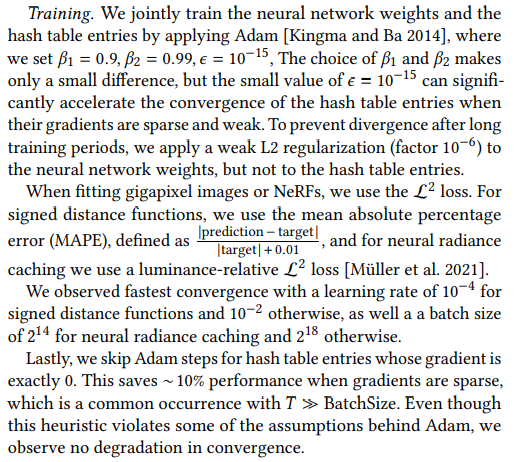

In [ ]:
def train_model(device, model: GridModel, img: Tensor, batch_size: int, steps: int, feature_mask: Optional[Tensor] = None):
  # Tensor[height, width]
  img = img.to(device)
  params = [
      {"params": model.grid.parameters(), "weight_decay": ??},
      {"params": model.mlp.parameters(), "weight_decay": ??},
  ]
  optim = torch.optim.Adam(params, lr= ??, betas= ??, eps= ??, weight_decay=0)
  loss_fn = ??

  pbar = tqdm(range(steps))
  for _ in pbar:
    # Tensor[batch_size, 2]
    # Generate batch using random coordinates in [0,1] and then sampling from the picture
    train_x = ??
    train_y = sample_image(img, train_x)

    res = model.forward(train_x, feature_mask).squeeze()
    loss = loss_fn(res, train_y)
    optim.zero_grad()
    loss.backward()
    optim.step()

    render_img = render_image(device, model, (512, 512))
    transform = T.ToPILImage()
    render_img = transform(render_img)
    IMG_SEQ.append(render_img)

    loss = loss.item()
    pbar.set_description(f"Loss: {loss}")

Now you have implemented everything required to learn a high-quality implicit neural representation of arbitrary images (and even other objects in n-dimensional space).

You can now run the training code to see the results. They should appear very quickly (within roughly 10 seconds). You will see just how incredible this research is by the speed of the training loop, the rate of convergence and the quality of the output. 

**If you implementation is correct, you should see a final loss of less than 0.002 after 200 epochs.**

In [ ]:
# Source: https://commons.wikimedia.org/wiki/File:Albert_Einstein_1947.jpg
# The downloaded image is a cropped version of the original so that the image is a square
img = load_picture("https://drive.google.com/uc?id=1pWSutVFtWLo8XJqpKL6AgqUC5eeIG9IG")
plt.imshow(img, cmap='gray', vmin=0, vmax=1)

In [ ]:
torch.manual_seed(1337)

# IMG_SEQ is used to store the intermediate output of the model.
# You will use this in Question 4.
IMG_SEQ = list()

##############################################################
# You can play around with the hyperparameters in this section
##############################################################
n_levels = 16
cfg = PaperHashGridConfig(16, 1 << 19, 17)
model = GridModel(device, cfg, n_levels, 2, 2, 1, [64, 64])
##############################################################

cfg.print_stats(n_levels, 2)
train_model(device, model, img, 1 << 16, 200)

render_img = render_image(device, model, (512, 512))
transform = T.ToPILImage()
render_img = transform(render_img)

render_img.show()

### Generate the Submission Log

Please download `submission_log.json` and submit it to Gradescope.

In [ ]:
with open("submission_log.json", "w", encoding="utf-8") as f:
    json.dump(TO_SAVE, f)

## Use Cases

You are now familiar with a state-of-the-art approach for learning INRs. However, the presented model can be viewed as only being a building block for any downstream task. There are countless applications of this technology and while this assignment is only focused around the immediate implementation, this section will give a small overview of applications that have already been demonstrated. 

**It may be very helpful and interesting to read through this section, even though it is not required for the assignment. This technology has great potential in many research areas and might even be relevant for your own research if applicable.**

### Immediate Applications

We will start off with the use cases mentioned by the instant-ngp paper, as they are the most straight forward. Additionally, they are immediate uses of the technology and do not involve any additional models.

#### 1. Image super resolution

An INR essentially converts the discontinuous function of the pixel-based image lookup table into a continuous function. This makes it possible to sample the model "between pixels". For example, it can be trained on a `512x512` picture, but could be sampled as `1024x1024`, therefore making the original picture 400% larger. Compared to other approaches, this does not have the ability to add detail that was not present in the original picture (it cannot make up things), but it is more reliable because of exactly that fact. It can be viewed as "fancy interpolation" for the purposes of upscaling.

#### 2. Signed Distance Functions

In short, a signed distance function represents a 3D shape by outputting a distance to the closest surface point for each point in 3D space (the surface could be reconstructed by only rendering those points with a distance=0). They have countless applications, which we won't go into here. However, they are clasically stored in a dense grid, which has the downside of consuming a lot of memory and being limited by precision (exactly the same problems that INRs had before instant-ngp). The INR can be applied to this problem, resulting in a "neural SDF", which is a continuous function representing exactly the desired distance function. 

#### 3. Neural Radiance Caching

Neural radiance caching is the task of training a neural network to predict the photorealistic pixel colors (light values) in a virtual 3D environment. If the neural radiance cache is fast and good enough (which it is with instant-ngp), it can replace parts of traditional rendering (requiring less light rays to be calculated by the hardware). This has the potential to speed up any 3D rendering application, from games and movies to scientific visualizations. 

#### 4. Neural Radiance and Density Fields (NeRF)

A NeRF assigns a colored density value for each coordinate at each view position and view angle. In short, one possible application of this is in photogrammetry - the task of reconstructing a 3D environment based on a few pictures. The paper goes into a lot more detail about this, and it is one of the main use cases presented by the authors. They also provide a [playground application](https://github.com/NVlabs/instant-ngp) where you can train NeRFs yourself and explore the capabilities of the encoding. 

### Other Applications

#### 1. Spatial data compression

The entire model can be serialized to disk after being trained on any task (for example on 2D images). At this point, it can already take up much less space than the original image when stored as a PNG. However, it could be further compressed by utilizing pruning and quantization, at which point it could become a competitive compression method for not only 2D image data, but any n-dimensional data. 

#### 2. 3D and 4D shape generation

Very recent research has shown how an INR can be used to generate high quality 3D objects and even 4D fields of 3D objects evolving over time (animated 3D objects). The authors of [HyperDiffusion](https://ziyaerkoc.com/hyperdiffusion/) propose using a diffusion model to generate the weights of an INR model. The generated weights can then be used to generate the final output. This is a great use case that shows the power of using an INR for downstream tasks (or in this case, using it as a downstream representation). Please take a look at the paper if you want more details.

#### 3. Representing sound

Another very recent paper [Hypernetworks build Implicit Neural Representations of Sounds](https://arxiv.org/abs/2302.04959) discusses an approach to efficiently generate an INR for sound, to not only predict samples that were not present in the original audio, but also to use it as an alternative for other audio encoding methods (like spectograms) for other downstream tasks. This has the potential to affect many other problems involving the processing, classification or generation of audio by neural networks. 

Furthermore, the [awesome-implicit-representations](https://github.com/vsitzmann/awesome-implicit-representations) GitHub repository contains links to some of the mentioned papers and many more, in addition to notebooks covering some other approaches to generating INRs. 

# Task 4

By now, you have already put this solid and effective multiresolution hash encoding model into practice. The questions that follow will lead you through a visualization of the model's workflow and aid in your understanding of the variations in model outputs at various timescales as well as the function that various layers play in multiresolution.

## Question 4 (a)

Recap Figure 3 of the paper (You can also see it in the introduction to Task 3). Each point in a grid layer has its layer representation determined by a bilinear interpolation of the four nearby grid corners. A point in each layer of the $L$ grid is interpolated to create an $F$-dimensional feature, and an auxiliary vector in the $E$ dimension is concatenated to create an representation $ \mathrm{y}\in R^{LF+E}$.

In this section, we will use the method `interpolate` of `scipy` to visualize the results of bilinear interpolation. This is a simple visualization, so we'll use simple randomly generated vectors $F\in R^2$ here, or you can visualize the model's Hash Table yourself!

In [ ]:
import numpy as np
from scipy.interpolate import interp2d
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
'''
Input: A grid tensor(grid_N+1, grid_N+1, F=2). Size is used to set the pixel edge length of each grid of the image
Output: A grayscale image.
For a two-dimensional vector F, we add its two dimensions and compress them to between [0, 255].
'''
def gray_visual_interpolation(input_tensor, size=50):

  grid_N = input_tensor.shape[0]-1
  grid_F = input_tensor.shape[2]

  grid = np.zeros((size*grid_N, size*grid_N), np.uint8)

  # tensor(4,4,2,) -> tensor(4,4,)
  sum_input_tensor = np.sum(input_tensor, axis=2).reshape((grid_N+1, grid_N+1))

  # [0,2] -> [0, 255]
  # Note: If you initialize your vector outside of the [0, 1] range, change the value of v_zoom!
  v_zoom = 127.5
  sum_input_tensor = np.round(sum_input_tensor * v_zoom).astype(np.uint8)

  for i in range(grid_N):
    for j in range(grid_N):

      Z = np.zeros((size, size))
      Z[0, 0] = sum_input_tensor[i,j]
      Z[0, -1] = sum_input_tensor[i,j+1]
      Z[-1, 0] = sum_input_tensor[i+1,j]
      Z[-1, -1] = sum_input_tensor[i+1,j+1]

      x = np.array([0, size-1])
      y = np.array([0, size-1])
      z = np.array([[Z[0][0], Z[0][-1]],
              [Z[-1][0], Z[-1][-1]]])
      
      #################################################################
      # TODO: Implement the bilinear interpolation.
      #
      # Hint : Use import interp2d from scipy.interpolate.
      #################################################################
      raise NotImplementedError()
      #################################################################
      # End of the implementation
      #################################################################

      grid[i*size:(i+1)*size, j*size:(j+1)*size] = output

  return grid



'''
Input: A grid tensor(grid_N+1, grid_N+1, F=2). Size is used to set the pixel edge length of each grid of the image
Output: An BGR image.
We can use the kernel method to expand the two-dimensional feature vectors to three channels.
[f1, f2] -> [f1^2, f2^2, f1x2]
Note: This visualization method is not unique, you can add other parameters to adjust the range of parameters!
'''
def bgr_visual_kernel_interpolation(input_tensor, size=50):

    grid_N = input_tensor.shape[0]-1
    grid_F = input_tensor.shape[2]

    grid = np.zeros((size * grid_N, size * grid_N, 3), np.uint8)

    # 3 Channels.
    for c in range(3):
        if c != 2:
          c_input = np.uint8(input_tensor[:,:,c] ** 2)
          for i in range(grid_N):
              for j in range(grid_N):
                  Z = np.zeros((size, size))
                  Z[0, 0] = c_input[i, j]
                  Z[0, -1] = c_input[i, j + 1]
                  Z[-1, 0] = c_input[i + 1, j]
                  Z[-1, -1] = c_input[i + 1, j + 1]

                  x = np.array([0, size - 1])
                  y = np.array([0, size - 1])
                  z = np.array([[Z[0][0], Z[0][-1]], [Z[-1][0], Z[-1][-1]]])

                  f = interp2d(x, y, z, kind='linear')

                  output = f(np.arange(size), np.arange(size))
                  output = np.round(output)
                  output = np.uint8(output)

                  grid[i * size:(i + 1) * size, j * size:(j + 1) * size, c] = output
        else:
          #################################################################
          # TODO: Implement the bilinear interpolation in channel 3.
          #################################################################
          raise NotImplementedError()
          #################################################################
          # End of the implementation
          #################################################################

    return grid

In [ ]:
## Test for gray_visual_interpolation().
# You can adjust the values of grid_N and size!
grid_N = 10
input_tensor = np.random.rand(grid_N+1, grid_N+1, 2)
grid = gray_visual_interpolation(input_tensor, size=60)
cv2_imshow(grid)

In [ ]:
## Test for bgr_visual_interpolation().
# You can adjust the values of grid_N and size!
grid_N = 10
input_tensor = np.random.rand(grid_N+1, grid_N+1, 2)
input_tensor = np.round(input_tensor * 255).astype(np.uint8)
grid = bgr_visual_kernel_interpolation(input_tensor, size=60)
cv2_imshow(grid)

## Question 4 (b)

Next, we will use the IMG_SEQ generated in Task 3 to observe the output of the model at different timestep. This work is complete and you can look at the `train_model()` to get more details. They are saved through these codes:

```python
# The tuple in the render_image call is the width/height of the resulting image. 
# Note: super resolution could be done 
# by setting this to be larger than the size of the input image.
render_img = render_image(device, model, (512, 512))
transform = T.ToPILImage()
render_img = transform(render_img)
IMG_SEQ.append(render_img)
```

In [ ]:
# IMG_SEQ -> List of PILImage objects.
# You can see them by PILImage.show().
# This will display a gray image.
IMG_SEQ[20].show()

In [ ]:
import matplotlib.pyplot as plt

# Also, you can see it by matplotlib.
# This will display a color image.
fig, ax = plt.subplots()
implot = ax.imshow(IMG_SEQ[5])

# plt.close('all')

In [ ]:
# Note: The slider generated by this snippet does not work due to certain bugs in Colab. 
# You can use this slider in your local environment to watch the image change.
'''
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install ipympl
%matplotlib widget

from google.colab import output
import matplotlib.image as mpimg
output.enable_custom_widget_manager()
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button

fig, ax = plt.subplots()

implot = ax.imshow(IMG_SEQ[0])

slider_ax = plt.axes([0.2, 0.05, 0.6, 0.05])
slider = Slider(slider_ax, 'Image', 0, len(IMG_SEQ)-1, valinit=0, valstep=1)

def update(val):
    index = int(val)
    implot.set_data(IMG_SEQ[index])
    fig.canvas.draw_idle()

slider.on_changed(update)
plt.show()
'''

## Question 4 (c)

Finally, We will explore the role of different layers in the generation of results in this section. 

First, let's see what will happen if the parameters of the specified layer are not updated during training:

In [ ]:
torch.manual_seed(1337)
IMG_SEQ = list()

n_levels = 16
cfg = PaperHashGridConfig(16, 1 << 19, 17)
model = GridModel(device, cfg, n_levels, 2, 2, 1, [64, 64])

cfg.print_stats(n_levels, 2)

#################################################################
# TODO: Implement train_model. 
#
# Hint : Use the method get_feature_mask() of model to make a model feature mask.
#################################################################
raise NotImplementedError()
#################################################################
# End of the implementation
#################################################################

render_img = render_image(device, model, (512, 512))
transform = T.ToPILImage()
render_img = transform(render_img)
render_img.show()

Then, let's see the images generated by using different layers after the model is trained:

In [ ]:
torch.manual_seed(1337)
IMG_SEQ = list()

n_levels = 16
cfg = PaperHashGridConfig(16, 1 << 19, 17)
model = GridModel(device, cfg, n_levels, 2, 2, 1, [64, 64])

cfg.print_stats(n_levels, 2)
train_model(device, model, img, 1 << 16, 200)


#################################################################
# TODO: Implement render_img. 
# This generated image is only output by the specified layer（s） of the trained model.
#
# Hint : Use the method get_feature_mask() of model to make a model feature mask.
#################################################################
raise NotImplementedError()
#################################################################
# End of the implementation
#################################################################
transform = T.ToPILImage()
render_img = transform(render_img)
render_img.show()